## XGBoost Regerssor
- Objective
    - Utilizing the XGBoost sklearn API
    - Using Regressor instead of Classification
- References
    - https://brunch.co.kr/@snobberys/137
    - https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf

In [1]:
!pip3 install sacred

In [2]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.0 MB/s eta 0:00:0000:0100:010m


In [7]:
!pip install pandas-gbq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.3/120.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.5/215.5 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.0/223.0 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.2/397.2 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 19.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: requests
    Found existing installation: requests 1.2.3
    Uninstalling requests-1.2.3:
      Successfully uninstalled requests-1.2.3
  Attempting uninstall: p

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
import numpy as np
from sacred import Experiment
from sacred.observers import FileStorageObserver
from xgboost import XGBRegressor
import json

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='nyctaxi-demand-forecast'

In [5]:
ex = Experiment('nyc-demand-prediction', interactive=True)

# if experiment_dir doesn't exist, create a folder and save as FileStorageObserver
experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

### Pre-Processing

In [8]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=vVKXOKI2dWB5EmNoJSm5kkar8wEOAf&access_type=offline
CPU times: user 1.45 s, sys: 297 ms, total: 1.75 s
Wall time: 32.4 s


### Data Preprocessing
- Label Encoding instead of One Hot Encoding

In [26]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [10]:
def split_train_and_test(df, date):
    """
    Divide by train_df, test_df functions on a dataframe
    
    df : time series dataframe
    date : reference point date
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Split Train / Test

In [31]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [32]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_le
65113,11106,2015-01-23 23:00:00+00:00,1,23,4,23,0,34,189
65114,10003,2015-01-23 23:00:00+00:00,1,23,4,23,0,2310,2
65115,10454,2015-01-23 23:00:00+00:00,1,23,4,23,0,1,83
65116,11435,2015-01-23 23:00:00+00:00,1,23,4,23,0,2,277
65117,11208,2015-01-23 23:00:00+00:00,1,23,4,23,0,1,197


- Delete unused columns

In [33]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [34]:
train_df.head(4)

,month,day,weekday,hour,is_weekend,cnt,zip_code_le
0,1,1,3,0,0,169,191
1,1,1,3,0,0,10,58
2,1,1,3,0,0,120,23
3,1,1,3,0,0,6,92


In [35]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [36]:
x_train = train_df.copy()
x_test = test_df.copy()

### Modeling

In [37]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [38]:
@ex.config
def config():
    max_depth=5
    learning_rate=0.1
    n_estimators=100
    n_jobs=-1

In [39]:
@ex.capture
def get_model(max_depth, learning_rate, n_estimators, n_jobs):
    return XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, n_jobs=n_jobs)

In [40]:
@ex.main
def run(_log, _run):
    global xgb_reg, xgb_pred
    xgb_reg = get_model()
    xgb_reg.fit(x_train, y_train_raw)
    xgb_pred = xgb_reg.predict(x_test)
    score = evaluation(y_test_raw, xgb_pred)
    
    _run.log_scalar('model_name', xgb_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [41]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "4"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 538.5201561766138}, 'mae': {'score': 57.67873599873819}, 'mse': {'score': 16512.3302373418}}
INFO - nyc-demand-prediction - Completed after 0:00:01


In [42]:
experiment_result.config

{'max_depth': 5,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'n_jobs': -1,
 'seed': 860999119}

In [54]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    metric_df = pd.DataFrame(json_data['metrics']['values'][0]['values'])
    
    output_df = pd.concat([output_df, metric_df], axis=1)
    output_df = output_df.round(2)
    return output_df

In [59]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/run.json') as json_file:
        json_data = json.load(json_file)
    output = pd.DataFrame(json_data['result'])
    return output

In [60]:
parsing_output(4)

,mae,mape,mse
score,57.678736,538.520156,16512.330237


<Axes: >

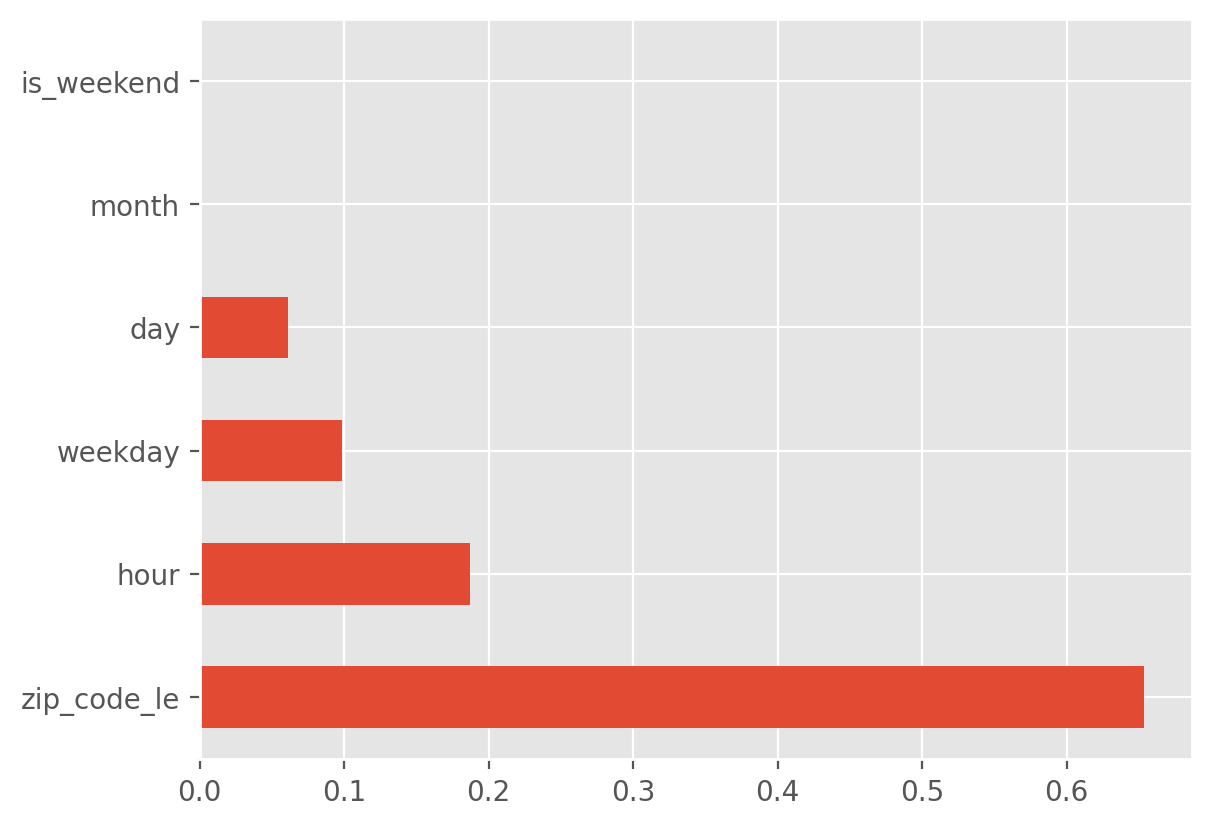

In [61]:
feat_importances = pd.Series(xgb_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')